In [1]:
# Import the necessary packages and modules

import os
import PIL
import scipy.stats
import numpy as np
import nibabel as nib
import dipy.reconst.dki as dki
import dipy.reconst.dti as dti
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
from skimage.morphology import erosion
from dipy.core.gradients import gradient_table

In [2]:
# Fit the signal models to phantom and volunteer data

os.system('python cumulant.py')
os.system('python higher_order.py')
os.system('python gamma.py')
os.system('python qti.py')

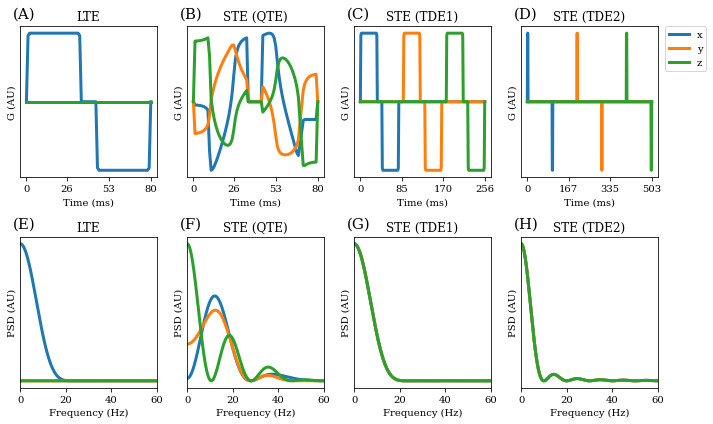

In [3]:
# Create the gradient waveform figure

plt.rcParams['font.family'] = 'serif'

def calc_power(waveform, T, N=int(1e5)):
    """Calculate the power spectrum of a gradient waveform."""
    q = np.cumsum(waveform)
    dt = T / (len(q) - 1)
    ps = np.abs(np.fft.fft(q, N))**2
    freqs = np.fft.fftfreq(N, dt)
    idx = np.argsort(freqs)
    return ps[idx], freqs[idx]

ste = np.loadtxt('../Preproc-data/waveform_STE.txt') 
lte = np.loadtxt('../Preproc-data/waveform_LTE.txt') 
T = 80e-3
t = np.linspace(0, T * 1e3, lte.shape[0])

n_zeros = 8
tde_1 = np.zeros((lte.shape[0] * 3 + n_zeros * 2, 3))
tde_1[0:78, 0] = lte[:, 0]
tde_1[78 + n_zeros:78 + n_zeros + 78, 1] = lte[:, 0]
tde_1[78 + n_zeros + 78 + n_zeros::, 2] = lte[:, 0]
tde_1_T = T * tde_1.shape[0] / lte.shape[0]
tde_1_t = np.linspace(0, tde_1_T * 1e3, tde_1.shape[0])

tde_2 = np.zeros((504, 3))
tde_2[1:3, 0] = 1
tde_2[101:103, 0] = -1
tde_2[201:203, 1] = 1
tde_2[301:303, 1] = -1
tde_2[401:403, 2] = 1
tde_2[501:503, 2] = -1
tde_2_T = 503e-3
tde_2_t = np.linspace(0, tde_2_T * 1e3, tde_2.shape[0])

fig, ax = plt.subplots(2, 4, figsize=(10, 6))
for i in range(3):
    ax[0, 0].plot(t, lte[:, i], lw=3)
    ax[0, 1].plot(t, ste[:, i], lw=3)
    ax[0, 2].plot(tde_1_t, tde_1[:, i], lw=3)
    ax[0, 3].plot(tde_2_t, tde_2[:, i], lw=3)
    ps, freqs = calc_power(lte[:, i], T)
    ax[1, 0].plot(freqs, ps, lw=3)
    ps, freqs = calc_power(ste[:, i], T)
    ax[1, 1].plot(freqs, ps, lw=3)
    ps, freqs = calc_power(tde_1[:, 1], tde_1_T)
    ax[1, 2].plot(freqs, ps, lw=3)
    ps, freqs = calc_power(tde_2[:, 1], tde_2_T)
    ax[1, 3].plot(freqs, ps, lw=3)
titles = ['LTE', 'STE (QTE)', 'STE (TDE1)', 'STE (TDE2)']
labels = ['(A)', '(B)', '(C)', '(D)', '(E)', '(F)', '(G)', '(H)']
for i in range(4):
    for j in range(2):
        ax[j, i].set_title(titles[i])
        k = j * 4 + i
        ax[j, i].text(-0.05, 1.04, labels[k], verticalalignment='bottom',
                   horizontalalignment='left', fontsize=15, color='black',
                   fontdict={'family' : 'serif'}, transform=ax[j, i].transAxes)
        ax[j, i].set_yticks([])
    ax[0, i].set_xlabel('Time (ms)')
    ax[0, i].set_ylabel('G (AU)')
    ax[1, i].set_xlabel('Frequency (Hz)')
    ax[1, i].set_ylabel('PSD (AU)')
    ax[1, i].set_xlim([0, 60])       
    ax[1, i].set_xticks(np.linspace(0, 60, 4).astype(int))
ax[0, 3].legend(['x', 'y', 'z'], bbox_to_anchor=(1.05, 1),
             loc='upper left', borderaxespad=0.)
ax[0, 0].set_xticks(np.linspace(0, T * 1e3, 4).astype(int))
ax[0, 1].set_xticks(np.linspace(0, T * 1e3, 4).astype(int))
ax[0, 2].set_xticks(np.linspace(0, tde_1_T * 1e3, 4).astype(int))
ax[0, 3].set_xticks(np.linspace(0, tde_2_T * 1e3, 4).astype(int))
plt.tight_layout()
plt.show()
fig.savefig('../LaTeX/Figures/waveforms.pdf')

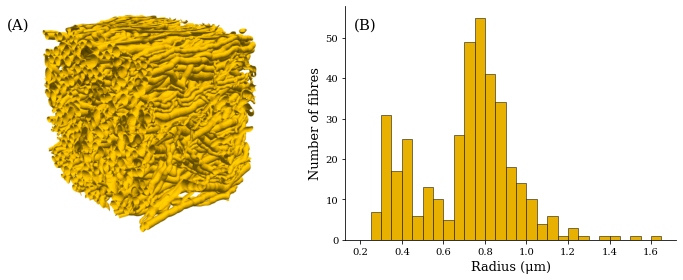

In [4]:
# Create the mesh figure

radii = np.loadtxt('ConFiG/mean_rad.txt')
img = np.array(PIL.Image.open('../LaTeX/Figures/config_mesh.png'))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(img)
ax[0].axis('off')
hs = ax[1].hist(radii, edgecolor='black', color=(233/256, 178/256, 0),
                bins=np.arange(4, 34) / 20, linewidth=.5)
ax[1].set_xlabel('Radius (μm)', fontsize=13)
ax[1].set_ylabel('Number of fibres', fontsize=13)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].text(-0.1, .95, '(A)', verticalalignment='top',
           horizontalalignment='left', fontsize=15, color='black',
           fontdict={'family' : 'serif'}, transform=ax[0].transAxes)
ax[1].text(0.025, .95, '(B)', verticalalignment='top',
           horizontalalignment='left', fontsize=15, color='black',
           fontdict={'family' : 'serif'}, transform=ax[1].transAxes)
plt.tight_layout()
plt.show()
fig.savefig('../LaTeX/Figures/mesh_figure.pdf', dpi=500)

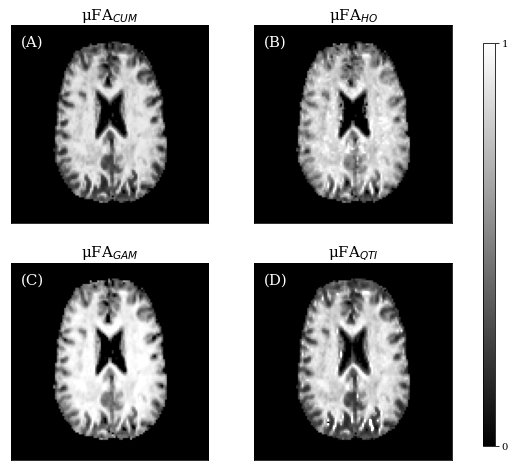

In [5]:
# Create the μFA maps figure

cum_uFA = np.zeros((3, 128, 128, 60))
ho_uFA = np.zeros((3, 128, 128, 60))
gam_uFA = np.zeros((3, 128, 128, 60))
qti_uFA = np.zeros((3, 128, 128, 60))
mask = np.zeros((3, 128, 128, 60))

for i in range(3):
    cum_uFA[i] = nib.load(
        '../Results/Volunteer-%s/cum_uFA.nii.gz' % (i + 1)).get_fdata()
    ho_uFA[i] = nib.load(
        '../Results/Volunteer-%s/ho_uFA.nii.gz' % (i + 1)).get_fdata()
    gam_uFA[i] = nib.load(
        '../Results/Volunteer-%s/gam_uFA.nii.gz' % (i + 1)).get_fdata()
    qti_uFA[i] = nib.load(
        '../Results/Volunteer-%s/qti_uFA.nii.gz' % (i + 1)).get_fdata()
    mask[i] = nib.load(
        '../Preproc-data/Volunteer-%s/mask.nii.gz' % (i + 1)).get_fdata()

for _ in range(2):  # Erode masks to exclude voxels of CSF near the skull
    for i in range(3):
        mask[i] = erosion(mask[i])
mask = mask.astype(bool)

cum_uFA[~mask] = np.nan
ho_uFA[~mask] = np.nan
gam_uFA[~mask] = np.nan
qti_uFA[~mask] = np.nan
cum_uFA[np.isnan(cum_uFA)] = 0
ho_uFA[np.isnan(ho_uFA)] = 0
gam_uFA[np.isnan(gam_uFA)] = 0
qti_uFA[np.isnan(qti_uFA)] = 0

k = 33  # Slice to show
vmin = 0
vmax = 1
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax[0, 0].imshow(np.rot90(cum_uFA[0, 10:118, 10:118, k]), vmin=vmin, vmax=vmax,
                cmap='gray')
ax[0, 1].imshow(np.rot90(ho_uFA[0, 10:118, 10:118, k]), vmin=vmin, vmax=vmax,
                cmap='gray')
ax[1, 0].imshow(np.rot90(gam_uFA[0, 10:118, 10:118, k]), vmin=vmin, vmax=vmax,
                cmap='gray')
im = ax[1, 1].imshow(np.rot90(qti_uFA[0, 10:118, 10:118, k]), vmin=vmin,
                     vmax=vmax, cmap='gray')
labels = ['(A)', '(B)', '(C)', '(D)']
titles = ['μFA$_{CUM}$', 'μFA$_{HO}$', 'μFA$_{GAM}$', 'μFA$_{QTI}$']
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, .7])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=[vmin, vmax])
cbar.set_ticks([vmin, vmax])
for i in range(2):
    for j in range(2):
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        k = i * 2 + j
        ax[i,j].text(.05, .95, labels[k], verticalalignment='top',
                     horizontalalignment='left', fontsize=15, color='white',
                     fontdict={'family' : 'serif'},
                     transform=ax[i, j].transAxes)
        ax[i,j].set_title(titles[k], fontsize=15)
plt.show()
fig.savefig('../LaTeX/Figures/uFA_maps.pdf', bbox_inches="tight")

In [6]:
# Quantify the orientational variance of the STE acquisition

data = np.zeros((3, 128, 128, 60, 214))
bvals = np.zeros((3, 214))
bvecs = np.zeros((3, 3, 214))
for i in range(3):
    data[i] = nib.load(
        '../Preproc-data/Volunteer-%s/LTE-STE.nii.gz' % (i + 1)).get_fdata()
    bvals[i] = np.loadtxt(
        '../Preproc-data/Volunteer-%s/LTE-STE.bval' % (i + 1))
    bvecs[i] = np.loadtxt(
        '../Preproc-data/Volunteer-%s/LTE-STE.bvec' % (i + 1))
lte_idx = np.arange(107)
ste_idx = np.arange(107, 214)

lte_fa = np.zeros((3, 128, 128, 60)) 
ste_fa = np.zeros((3, 128, 128, 60)) 
for i in range(3):
    gtab = gradient_table(bvals[i, lte_idx], bvecs[i, :, lte_idx])
    dtimodel = dti.TensorModel(gtab)
    dtifit = dtimodel.fit(data[i, :, :, :, 0:107], mask=mask[i])
    lte_fa[i] = dtifit.fa
    gtab = gradient_table(bvals[i, ste_idx], bvecs[i, :, ste_idx])
    dtimodel = dti.TensorModel(gtab)
    dtifit = dtimodel.fit(data[i, :, :, :, 107::], mask=mask[i])
    ste_fa[i] = dtifit.fa

x, y = lte_fa[mask].ravel(), ste_fa[mask].ravel()
idx = (x != 0) * (y != 0)
x, y = x[idx], y[idx]
print('R = %s (p = %s)' % scipy.stats.pearsonr(x, y))

R = 0.21719616756138474 (p = 0.0)


/home/leevi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


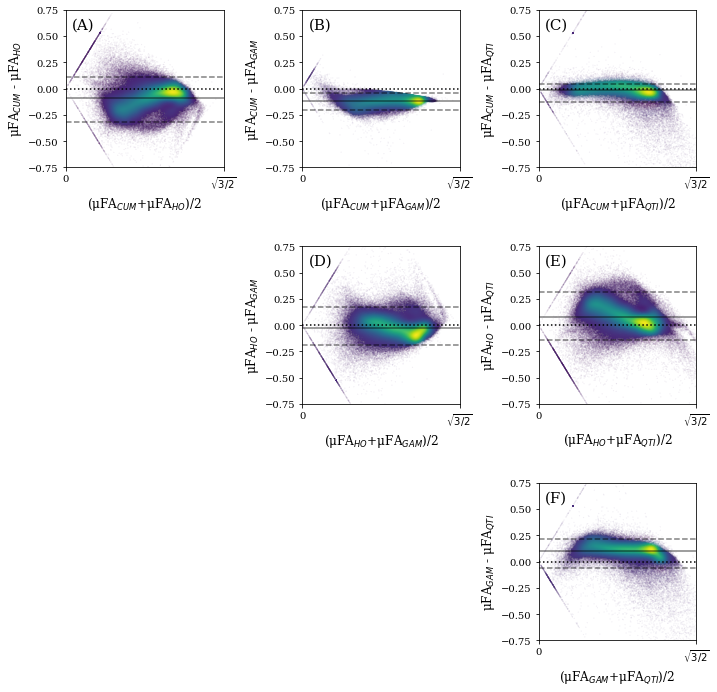

Mean uFA cumulant = 0.6214989126272644
Mean uFA higher order = 0.7067813112395228
Mean uFA gamma = 0.736024478729623
Mean uFA QTI = 0.6335662431549358

Cumulant vs higher order
Mean difference = -0.08528239861225852
ll, ul, width = -0.3152384594651872, 0.10832091032929364, 0.42355936979448083
LinregressResult(slope=0.15469602176523767, intercept=-0.18802223182307415, rvalue=0.24814327008413906, pvalue=0.0, stderr=0.0009763361870297044)

Cumulant vs gamma
Mean difference = -0.11452556610235877
ll, ul, width = -0.20515365227516183, -0.03818313510701158, 0.16697051716815026
LinregressResult(slope=0.06089788788041455, intercept=-0.1558607197433047, rvalue=0.270038561907854, pvalue=0.0, stderr=0.00035104099216373046)

Cumulant vs QTI
Mean difference = -0.012067330527671505
ll, ul, width = -0.1252378847335143, 0.046628953704851914, 0.1718668384383662
LinregressResult(slope=-0.15710434953881852, intercept=0.08652076693632772, rvalue=-0.3150780497320837, pvalue=0.0, stderr=0.000765049162121553

In [7]:
# Create the voxel-wise comparison figure

MD = np.zeros((3, 128, 128, 60))
for i in range(3):
    MD[i] = nib.load(
        '../Results/Volunteer-%s/cum_MD.nii.gz' % (i + 1)).get_fdata()
mask *= (MD < 2)  # CSF masking
cum_uFA[~mask] = np.nan
ho_uFA[~mask] = np.nan
gam_uFA[~mask] = np.nan
qti_uFA[~mask] = np.nan

def density_scatter(x, y, ax, **kwargs):
    """Create a scatter plot where colour reflects point density."""
    data, x_e, y_e = np.histogram2d(
        x, y, range=[[0, np.sqrt(1.5)], [-np.sqrt(1.5), np.sqrt(1.5)]], bins=30,
        density=True)
    z = interpn((0.5 * (x_e[1:] + x_e[:-1]), 0.5 * (y_e[1:] + y_e[:-1])), data,
                 np.vstack([x, y]).T, method="splinef2d", bounds_error=False)
    z[np.where(np.isnan(z))] = 0.0
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    ax.scatter(x, y, c=z, **kwargs)
    return

fig, ax = plt.subplots(3, 3, figsize=(10, 10))

y1 = cum_uFA.ravel() - ho_uFA.ravel()
x1 = (cum_uFA.ravel() + ho_uFA.ravel()) / 2
idx = ~np.isnan(x1 * y1)
x1, y1 = x1[idx], y1[idx]
a1 = cum_uFA.ravel()[idx]
b1 = ho_uFA.ravel()[idx]
ll1 = np.percentile(y1, 2.5)
ul1 = np.percentile(y1, 97.5)
ax[0,0].plot([0, np.sqrt(1.5)], [np.mean(y1), np.mean(y1)], color='black',
             alpha=.5)
ax[0,0].plot([0, np.sqrt(1.5)], [ul1, ul1], ls='--', color='black', alpha=.5)
ax[0,0].plot([0, np.sqrt(1.5)], [ll1, ll1], ls='--', color='black', alpha=.5)
density_scatter(x1, y1, ax=ax[0,0], s=.01, alpha=.25)
ax[0,0].set_ylabel('μFA$_{CUM}$ - μFA$_{HO}$', size=12)
ax[0,0].set_xlabel('(μFA$_{CUM}$+μFA$_{HO}$)/2', size=12)

y2 = cum_uFA.ravel() - gam_uFA.ravel()
x2 = (cum_uFA.ravel() + gam_uFA.ravel()) / 2
idx = ~np.isnan(x2 * y2)
x2, y2 = x2[idx], y2[idx]
a2 = cum_uFA.ravel()[idx]
b2 = gam_uFA.ravel()[idx]
ll2 = np.percentile(y2, 2.5)
ul2 = np.percentile(y2, 97.5)
ax[0,1].plot([0, np.sqrt(1.5)], [np.mean(y2), np.mean(y2)], color='black',
             alpha=.5)
ax[0,1].plot([0, np.sqrt(1.5)], [ul2, ul2], ls='--', color='black', alpha=.5)
ax[0,1].plot([0, np.sqrt(1.5)], [ll2, ll2], ls='--', color='black', alpha=.5)
density_scatter(x2, y2, ax=ax[0,1], s=.01, alpha=.25)
ax[0,1].set_ylabel('μFA$_{CUM}$ - μFA$_{GAM}$', size=12)
ax[0,1].set_xlabel('(μFA$_{CUM}$+μFA$_{GAM}$)/2', size=12)

y3 = cum_uFA.ravel() - qti_uFA.ravel()
x3 = (cum_uFA.ravel() + qti_uFA.ravel()) / 2
idx = ~np.isnan(x3 * y3)
x3, y3 = x3[idx], y3[idx]
a3 = cum_uFA.ravel()[idx]
b3 = qti_uFA.ravel()[idx]
ll3 = np.percentile(y3, 2.5)
ul3 = np.percentile(y3, 97.5)
ax[0,2].plot([0, np.sqrt(1.5)], [np.mean(y3), np.mean(y3)], color='black',
             alpha=.5)
ax[0,2].plot([0, np.sqrt(1.5)], [ul3, ul3], ls='--', color='black', alpha=.5)
ax[0,2].plot([0, np.sqrt(1.5)], [ll3, ll3], ls='--', color='black', alpha=.5)
density_scatter(x3, y3, ax=ax[0,2], s=.01, alpha=.25)
ax[0,2].set_ylabel('μFA$_{CUM}$ - μFA$_{QTI}$', size=12)
ax[0,2].set_xlabel('(μFA$_{CUM}$+μFA$_{QTI}$)/2', size=12)

y4 = ho_uFA.ravel() - gam_uFA.ravel()
x4 = (ho_uFA.ravel() + gam_uFA.ravel()) / 2
idx = ~np.isnan(x4 * y4)
x4, y4 = x4[idx], y4[idx]
a4 = ho_uFA.ravel()[idx]
b4 = gam_uFA.ravel()[idx]
ll4 = np.percentile(y4, 2.5)
ul4 = np.percentile(y4, 97.5)
ax[1,1].plot([0, np.sqrt(1.5)], [np.mean(y4), np.mean(y4)], color='black',
             alpha=.5)
ax[1,1].plot([0, np.sqrt(1.5)], [ul4, ul4], ls='--', color='black', alpha=.5)
ax[1,1].plot([0, np.sqrt(1.5)], [ll4, ll4], ls='--', color='black', alpha=.5)
density_scatter(x4, y4, ax=ax[1,1], s=.01, alpha=.25)
ax[1,1].set_ylabel('μFA$_{HO}$ - μFA$_{GAM}$', size=12)
ax[1,1].set_xlabel('(μFA$_{HO}$+μFA$_{GAM}$)/2', size=12)

y5 = ho_uFA.ravel() - qti_uFA.ravel()
x5 = (ho_uFA.ravel() + qti_uFA.ravel()) / 2
idx = ~np.isnan(x5 * y5)
x5, y5 = x5[idx], y5[idx]
a5 = ho_uFA.ravel()[idx]
b5 = qti_uFA.ravel()[idx]
ll5 = np.percentile(y5, 2.5)
ul5 = np.percentile(y5, 97.5)
ax[1,2].plot([0, np.sqrt(1.5)], [np.mean(y5), np.mean(y5)], color='black',
             alpha=.5)
ax[1,2].plot([0, np.sqrt(1.5)], [ul5, ul5], ls='--', color='black', alpha=.5)
ax[1,2].plot([0, np.sqrt(1.5)], [ll5, ll5], ls='--', color='black', alpha=.5)
density_scatter(x5, y5, ax=ax[1,2], s=.01, alpha=.25)
ax[1,2].set_ylabel('μFA$_{HO}$ - μFA$_{QTI}$', size=12)
ax[1,2].set_xlabel('(μFA$_{HO}$+μFA$_{QTI}$)/2', size=12)

y6 = gam_uFA.ravel() - qti_uFA.ravel()
x6 = (gam_uFA.ravel() + qti_uFA.ravel()) / 2
idx = ~np.isnan(x6 * y6)
x6, y6 = x6[idx], y6[idx]
a6 = gam_uFA.ravel()[idx]
b6 = qti_uFA.ravel()[idx]
ll6 = np.percentile(y6, 2.5)
ul6 = np.percentile(y6, 97.5)
ax[2,2].plot([0, np.sqrt(1.5)], [np.mean(y6), np.mean(y6)], color='black',
             alpha=.5)
ax[2,2].plot([0, np.sqrt(1.5)], [ul6, ul6], ls='--', color='black', alpha=.5)
ax[2,2].plot([0, np.sqrt(1.5)], [ll6, ll6], ls='--', color='black', alpha=.5)
density_scatter(x6, y6, ax=ax[2,2], s=.01, alpha=.25)
ax[2,2].set_ylabel('μFA$_{GAM}$ - μFA$_{QTI}$', size=12)
ax[2,2].set_xlabel('(μFA$_{GAM}$+μFA$_{QTI}$)/2', size=12)

for i in range(3):
    for j in range(i, 3):
        ax[i,j].plot([0, np.sqrt(1.5)], [0, 0], ls=':', color='black')
        ax[i,j].set_aspect(np.sqrt(1.5) / 1.5)
        ax[i,j].set_xlim([0, np.sqrt(1.5)])
        ax[i,j].set_ylim([-.75, .75])
        ax[i,j].set_xticks([0, np.sqrt(1.5)])
        ax[i,j].set_yticks([-.75, -.5, -.25, 0, .25, .5, .75])
        ax[i,j].set_xticklabels(['0', '$\sqrt{3/2}$'])
ax[1,0].axis('off')
ax[2,0].axis('off')
ax[2,1].axis('off')
ax[0,0].text(.05, .675, '(A)', fontsize=15, verticalalignment='top',
             horizontalalignment='left', fontdict={'family' : 'serif'})
ax[0,1].text(.05, .675,'(B)', fontsize=15, verticalalignment='top',
             horizontalalignment='left', fontdict={'family' : 'serif'})
ax[0,2].text(.05, .675,'(C)', fontsize=15, verticalalignment='top',
             horizontalalignment='left', fontdict={'family' : 'serif'})
ax[1,1].text(.05, .675,'(D)', fontsize=15, verticalalignment='top',
             horizontalalignment='left', fontdict={'family' : 'serif'})
ax[1,2].text(.05, .675, '(E)', fontsize=15, verticalalignment='top',
             horizontalalignment='left', fontdict={'family' : 'serif'})
ax[2,2].text(.05, .675, '(F)', fontsize=15, verticalalignment='top',
             horizontalalignment='left', fontdict={'family' : 'serif'})

fig.tight_layout()
plt.show()
fig.savefig('../LaTeX/Figures/ba_plots.png', dpi=400)

print('Mean uFA cumulant = %s' % np.nanmean(cum_uFA))
print('Mean uFA higher order = %s' % np.nanmean(ho_uFA))
print('Mean uFA gamma = %s' % np.nanmean(gam_uFA))
print('Mean uFA QTI = %s' % np.nanmean(qti_uFA))
print('')
print('Cumulant vs higher order')
print('Mean difference = %s' % np.mean(y1))
print('ll, ul, width = %s, %s, %s' % (ll1, ul1, abs(ll1 - ul1)))
print(scipy.stats.linregress(x1, y1))
print('')
print('Cumulant vs gamma')
print('Mean difference = %s' % np.mean(y2))
print('ll, ul, width = %s, %s, %s' % (ll2, ul2, abs(ll2 - ul2)))
print(scipy.stats.linregress(x2, y2))
print('')
print('Cumulant vs QTI')
print('Mean difference = %s' % np.mean(y3))
print('ll, ul, width = %s, %s, %s' % (ll3, ul3, abs(ll3 - ul3)))
print(scipy.stats.linregress(x3, y3))
print('')
print('Higher order vs gamma')
print('Mean difference = %s' % np.mean(y4))
print('ll, ul, width = %s, %s, %s' % (ll4, ul4, abs(ll4 - ul4)))
print(scipy.stats.linregress(x4, y4))
print('')
print('Higher order vs QTI')
print('Mean difference = %s' % np.mean(y5))
print('ll, ul, width = %s, %s, %s' % (ll5, ul5, abs(ll5 - ul5)))
print(scipy.stats.linregress(x5, y5))
print('')
print('Gamma vs QTI')
print('Mean difference = %s' % np.mean(y6))
print('ll, ul, width = %s, %s, %s' % (ll6, ul6, abs(ll6 - ul6)))
print(scipy.stats.linregress(x6, y6))

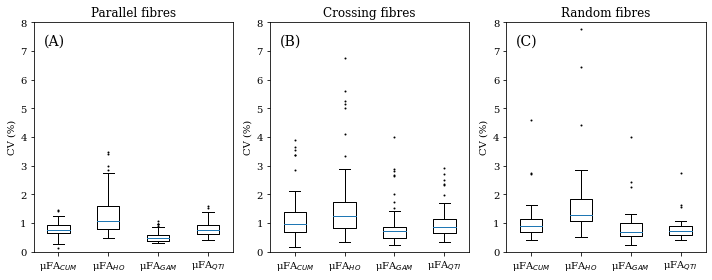

In [8]:
# Create the phantom figure

cum_uFAs = np.zeros((128, 128, 10, 11))
ho_uFAs = np.zeros((128, 128, 10, 11))
gam_uFAs = np.zeros((128, 128, 10, 11))
qti_uFAs = np.zeros((128, 128, 10, 11))

for i in range(11):
    cum_uFAs[:, :, :, i] = nib.load(
        '../Results/Phantom-%s/cum_uFA.nii.gz' % (i + 1)).get_fdata()
    ho_uFAs[:, :, :, i] = nib.load(
        '../Results/Phantom-%s/ho_uFA.nii.gz' % (i + 1)).get_fdata()
    gam_uFAs[:, :, :, i] = nib.load(
        '../Results/Phantom-%s/gam_uFA.nii.gz' % (i + 1)).get_fdata()
    qti_uFAs[:, :, :, i] = nib.load(
        '../Results/Phantom-%s/qti_uFA.nii.gz' % (i + 1)).get_fdata()
ROI_para = nib.load(
    '../Preproc-data/phantom_para_mask.nii.gz').get_fdata().astype(bool)
ROI_cros = nib.load(
    '../Preproc-data/phantom_cros_mask.nii.gz').get_fdata().astype(bool)
ROI_rand = nib.load(
    '../Preproc-data/phantom_rand_mask.nii.gz').get_fdata().astype(bool)
phantom_mask = nib.load(
    '../Preproc-data/Phantom-avg/mask.nii.gz').get_fdata().astype(bool)

fig, ax = plt.subplots(1, 3, figsize=(10, 4))
pos = [0, .7, 1.4, 2.1]
titles = ['Parallel fibres', 'Crossing fibres', 'Random fibres']
labels = ['(A)', '(B)', '(C)']
mu = .25 * (np.mean(cum_uFAs[phantom_mask]) + np.mean(ho_uFAs[phantom_mask])
      + np.mean(gam_uFAs[phantom_mask]) + np.mean(qti_uFAs[phantom_mask]))
for i, roi in enumerate([ROI_para, ROI_cros, ROI_rand]):
    ax[i].boxplot([100 * np.std(cum_uFAs[roi], axis=1) / mu,
                   100 * np.std(ho_uFAs[roi], axis=1) / mu,
                   100 * np.std(gam_uFAs[roi], axis=1) / mu,
                   100 * np.std(qti_uFAs[roi], axis=1) / mu],
                  medianprops={'color' : 'tab:blue'},
                  flierprops={'marker': 'o', 'markersize' : 1})
    ax[i].set_xticklabels(['μFA$_{CUM}$', 'μFA$_{HO}$', 'μFA$_{GAM}$',
                           'μFA$_{QTI}$'])
    ax[i].set_ylim([0, 8])
    ax[i].set_ylabel('CV (%)')
    ax[i].set_title(titles[i])
    ax[i].text(0.05, 0.95, labels[i], verticalalignment='top',
               horizontalalignment='left', fontsize=14,
               fontdict={'family' : 'serif'}, transform=ax[i].transAxes)
fig.tight_layout()
plt.show()
fig.savefig('../LaTeX/Figures/phantom_precision.pdf')

In [9]:
# Estimate SNR and compare mean estimates using averaged data

phantom_data = nib.load('../Preproc-data/Phantom-avg/LTE-STE.nii.gz').get_fdata()
phantom_bvals = np.loadtxt('../Preproc-data/Phantom-avg/LTE-STE.bval')
phantom_bvecs = np.loadtxt('../Preproc-data/Phantom-avg/LTE-STE.bvec')
phantom_b0_idx = np.where(phantom_bvals == 0)[0]
phantom_b0_data = phantom_data[:, :, :, phantom_b0_idx]
SNR = np.mean(np.mean(phantom_b0_data[phantom_mask], axis=1) /
              np.std(phantom_b0_data[phantom_mask], axis=1))
print('Mean SNR = %s\n' % SNR)

cum_uFA = nib.load('../Results/Phantom-avg/cum_uFA.nii.gz').get_fdata()
ho_uFA = nib.load('../Results/Phantom-avg/ho_uFA.nii.gz').get_fdata()
gam_uFA = nib.load('../Results/Phantom-avg/gam_uFA.nii.gz').get_fdata()
qti_uFA = nib.load('../Results/Phantom-avg/qti_uFA.nii.gz').get_fdata()
for i, roi in enumerate([ROI_para, ROI_cros, ROI_rand]):
    print(titles[i])
    print('Means: %s, %s, %s, %s' % (np.mean(cum_uFA[roi]),
                                          np.mean(ho_uFA[roi]),
                                          np.mean(gam_uFA[roi]),
                                          np.mean(qti_uFAs[roi])))
    print(scipy.stats.wilcoxon(cum_uFA[roi].ravel(), ho_uFA[roi].ravel()))
    print(scipy.stats.wilcoxon(cum_uFA[roi].ravel(), gam_uFA[roi].ravel()))
    print(scipy.stats.wilcoxon(cum_uFA[roi].ravel(), qti_uFA[roi].ravel()))
    print(scipy.stats.wilcoxon(ho_uFA[roi].ravel(), gam_uFA[roi].ravel()))
    print(scipy.stats.wilcoxon(ho_uFA[roi].ravel(), qti_uFA[roi].ravel()))
    print(scipy.stats.wilcoxon(gam_uFA[roi].ravel(), qti_uFA[roi].ravel()))
    print('')

Mean SNR = 123.0462307662343

Parallel fibres
Means: 0.8009560587317074, 0.8415390556895991, 0.9095243290944387, 0.8080225300524915
WilcoxonResult(statistic=0.0, pvalue=2.4770276393652366e-07)
WilcoxonResult(statistic=0.0, pvalue=2.4770276393652366e-07)
WilcoxonResult(statistic=49.0, pvalue=1.3194640243949197e-05)
WilcoxonResult(statistic=0.0, pvalue=2.4770276393652366e-07)
WilcoxonResult(statistic=0.0, pvalue=2.4770276393652366e-07)
WilcoxonResult(statistic=0.0, pvalue=2.4770276393652366e-07)

Crossing fibres
Means: 0.7439834633918356, 0.7727900336305612, 0.8540425131165407, 0.7352058378730223
WilcoxonResult(statistic=1.0, pvalue=8.031090907046913e-10)
WilcoxonResult(statistic=0.0, pvalue=7.556929455863566e-10)
WilcoxonResult(statistic=27.0, pvalue=3.784971871143241e-09)
WilcoxonResult(statistic=0.0, pvalue=7.556929455863566e-10)
WilcoxonResult(statistic=0.0, pvalue=7.556929455863566e-10)
WilcoxonResult(statistic=0.0, pvalue=7.556929455863566e-10)

Random fibres
Means: 0.6422452835560

In [10]:
# Quantify the orientational variance of the STE acquisition

lte_fa = np.zeros((128, 128, 10))
ste_fa = np.zeros((128, 128, 10))
gtab = gradient_table(phantom_bvals[lte_idx], phantom_bvecs[:, lte_idx])
dtimodel = dti.TensorModel(gtab)
dtifit = dtimodel.fit(phantom_data[:, :, :, lte_idx], mask=phantom_mask)
lte_fa = dtifit.fa
gtab = gradient_table(phantom_bvals[ste_idx], phantom_bvecs[:, ste_idx])
dtimodel = dti.TensorModel(gtab)
dtifit = dtimodel.fit(phantom_data[:, :, :, ste_idx], mask=phantom_mask)
ste_fa = dtifit.fa

x, y = lte_fa.ravel(), ste_fa.ravel()
idx = (x != 0) * (y != 0)
x, y = x[idx], y[idx]
print('R = %s (p = %s)' % scipy.stats.pearsonr(x, y))

R = 0.33661703268357857 (p = 3.1387053866660384e-17)


/home/leevi/Dropbox/PhD/QTE/Publication/Code/qti.py:133: RuntimeWarning: invalid value encountered in sqrt
  from_6x6_to_21x1(E_iso)))


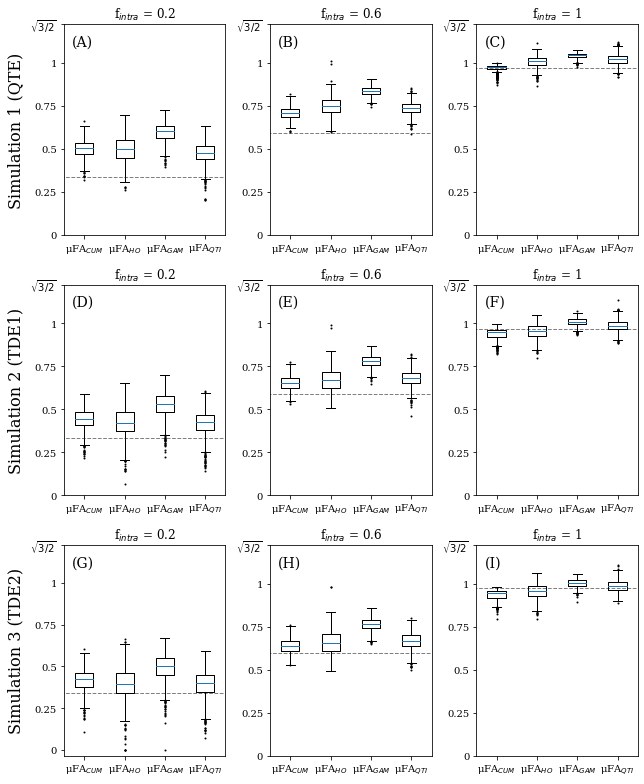


Ground truth ranges from 0.3354797601647804 to 0.9780218712145615

Cumulant MSE: 0.003194386266060219
Higher order MSE: 0.0026351807776560632
Gamma MSE: 0.017501566067496768
QTI MSE: 0.002746425816659055

Max bias caused by time-dependent diffusion
0.08472473538284392 0.10444098280900044 0.1020349371946177 0.08049105172884968


In [11]:
# Create the simulation figure


# Load data

path = '../Results'
signals = np.zeros((3, 382, 214))
for i in range(3):
    temp_signals = np.load(os.path.join(path, 'signals_%s.npy' % (i + 1)))
    for j in range(381):  # Intra-axonal
        signals[i, j + 1] = 1e-3 * np.nansum(
            temp_signals[:, int(j*1e3):int((j+1)*1e3)], axis=1)      
    signals[i, 0] = np.nansum(
        temp_signals[:, int(381e3)::], axis=1) / 219e3 # Extra-axonal
total_signals = np.zeros((3, 3, 214))
fs_ic = [.2, .6, 1]  # Intra-axonal signal fractions
weights = np.zeros((3, 382))
for i in range(3):
    for j, w in enumerate(fs_ic):
        weights[j] = np.ones(382) * w / 381
        weights[j, 0] = 1 - w
        total_signals[i, j] = np.sum(weights[j, :, np.newaxis] * signals[i],
                                     axis=0)

# Calculate ground-truth uFA

gt_uFA = np.zeros((3, 3))
lte_idx = np.arange(0, 107).astype(int)
ste_idx = np.arange(107, 214).astype(int)
bvals = np.loadtxt('../Preproc-data/Phantom-avg/LTE-STE.bval')[0:107] / 1e3
bvals = np.concatenate([bvals, bvals])
bs = np.unique(bvals)
bvecs = np.loadtxt('../Preproc-data/Phantom-avg/LTE-STE.bvec')[:, 0:107].T
bvecs = np.concatenate([bvecs, bvecs], axis=0)
gtab = gradient_table(bvals[lte_idx], bvecs[lte_idx])
dki_model = dki.DiffusionKurtosisModel(gtab)
for i in range(3):
    for j in range(3):
        evals = np.zeros((382, 3))
        for k in range(382):
            evals[k] = dki_model.fit(signals[i, k, lte_idx]).evals
        avg_eval_var = np.sum(weights[j] * np.var(evals, axis=1))
        avg_md_sq = np.sum(weights[j] * np.mean(evals, axis=1)**2)
        gt_uFA[i, j] = np.sqrt(1.5 * avg_eval_var / (avg_eval_var + avg_md_sq))


# Add noise to data and estimate uFA

import cumulant
import higher_order
import gamma
import qti

def fit_uFAs(signals):
    pa_lte = gamma.calc_pa(signals[lte_idx], bvals[lte_idx])
    pa_ste = gamma.calc_pa(signals[ste_idx], bvals[ste_idx])
    x = cumulant.fit_cum_model(pa_lte, pa_ste, np.unique(bvals))
    cum_uFA = cumulant.calc_uFA(x[1], x[3], x[2])
    x = higher_order.fit_ho_model(pa_lte, pa_ste, np.unique(bvals))
    ho_uFA = higher_order.calc_uFA(x[1], x[3], x[2])
    x = gamma.fit_gamma_model(pa_lte, pa_ste, np.unique(bvals))
    gam_uFA = gamma.calc_uFA(x[1], x[3], x[2])
    X = qti.calc_design_matrix(bvecs[lte_idx], bvals[lte_idx],
                               bvecs[ste_idx], bvals[ste_idx])
    S0_hat, D_hat, C_hat = qti.fit_qti(
        np.concatenate([signals[lte_idx], signals[ste_idx]]), X)
    qti_uFA = qti.calc_uFA(D_hat, C_hat)   
    return cum_uFA, ho_uFA, gam_uFA, qti_uFA

SNR = 25
N = int(1e4)
cum_uFAs = np.zeros((3, 3, N))
gam_uFAs = np.zeros((3, 3, N))
ho_uFAs = np.zeros((3, 3, N))
qti_uFAs = np.zeros((3, 3, N))
for i in range(3):
    for j in range(3):
        for k in range(N):
            print('%s/%s' % (i * (3 * N) + j * N + k, N * 3 * 3), end='\r')
            sigma = np.max(total_signals[i, j]) / SNR
            noisy_signals = np.abs(
                total_signals[i, j] + np.random.normal(
                    size=total_signals[i, j].shape, scale=sigma, loc=0)
                + 1j * np.random.normal(size=total_signals[i, j].shape,
                                        scale=sigma, loc=0))
            (cum_uFAs[i, j, k], ho_uFAs[i, j, k], gam_uFAs[i, j, k],
             qti_uFAs[i ,j, k]) = fit_uFAs(noisy_signals * 1e3)
            
    
# Create figure and print results

fig, ax = plt.subplots(3, 3, figsize=(9, 11))
pos = [0, .7, 1.4, 2.1]
for i in range(3):
    for j in range(3):
        ax[i, j].boxplot([cum_uFAs[i, j], ho_uFAs[i, j], gam_uFAs[i, j],
                          qti_uFAs[i, j][~np.isnan(qti_uFAs[i, j])]],
                         positions=pos, medianprops = {'color' : 'tab:blue'},
                         flierprops={'marker': 'o', 'markersize' : 1})
        ax[i, j].plot([-.5, 2.5], [gt_uFA[i, j], gt_uFA[i, j]], ls='--',
                      color='black', lw=1, alpha=.5)
labels = ['(A)', '(B)', '(C)', '(D)', '(E)', '(F)', '(G)', '(H)', '(I)']
encoding = ['Simulation 1 (QTE)', 'Simulation 2 (TDE1)', 'Simulation 3 (TDE2)']
for i in range(3):
    for j in range(3):
        k = i * 3 + j
        ax[i,j].set_xlim([-.35, 2.45])
        ax[i,j].set_yticks(np.concatenate([np.linspace(0, 1, 5),
                                           [np.sqrt(1.5)]]))
        ax[i,j].set_yticklabels(['0', '0.25', '0.5', '0.75', '1',
                                 '$\sqrt{3/2}$'])
        ax[i,j].set_xticks(pos)
        ax[i,j].set_xticklabels(['μFA$_{CUM}$', 'μFA$_{HO}$', 'μFA$_{GAM}$',
                               'μFA$_{QTI}$'])
        ax[i, j].set_title('f$_{intra}$ = %s' % fs_ic[j])
        ax[i, j].text(0.05, 0.95, labels[k], verticalalignment='top',
                      horizontalalignment='left', fontsize=14,
                      fontdict={'family' : 'serif'}, transform=ax[i, j].transAxes)
    ax[i, 0].text(-0.3, 0.5, encoding[i], verticalalignment='center',
                  horizontalalignment='center', fontsize=16, rotation=90,
                  fontdict={'family' : 'serif'}, transform=ax[i, 0].transAxes)
fig.tight_layout()
plt.show()
fig.savefig('../LaTeX/Figures/sim_results.pdf')

print('\nGround truth ranges from %s to %s' % (np.min(gt_uFA), np.max(gt_uFA)))
print('\nCumulant MSE: %s' % np.mean((np.mean(cum_uFAs, axis=2)[2] - gt_uFA[2])**2))
print('Higher order MSE: %s' % np.mean((np.mean(ho_uFAs, axis=2)[2] - gt_uFA[2])**2))
print('Gamma MSE: %s' % np.mean((np.mean(gam_uFAs, axis=2)[2] - gt_uFA[2])**2))
print('QTI MSE: %s' % np.mean((np.nanmean(qti_uFAs, axis=2)[2] - gt_uFA[2])**2))
print('\nMax bias caused by time-dependent diffusion')
print(np.max(np.nanmean(cum_uFAs, axis=2)[0] - np.nanmean(cum_uFAs, axis=2)[2]),
      np.max(np.nanmean(ho_uFAs, axis=2)[0] - np.nanmean(ho_uFAs, axis=2)[2]),
      np.max(np.nanmean(gam_uFAs, axis=2)[0] - np.nanmean(gam_uFAs, axis=2)[2]),
      np.max(np.nanmean(qti_uFAs, axis=2)[0] - np.nanmean(qti_uFAs, axis=2)[2]))